In [1]:
import random
import time
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

HV_STEP_COST = 1
D_STEP_COST = np.sqrt(2)

## Постановка эксперимента

**Цель**: провести сравнительное тестирование алгоритма A* с эвристикой `Octile` distance с алгоритмом WA* с эвристикой `Octile` для задачи планирования на 8-связном гриде. Далее под алгоритмами A* и WA* будут подразумеваться соответствующие алгоритмы с эвристикой `Octile` distance.

Тестировать алгоритмы мы будем на трех различных гридах (**картах**) -- `Moscow_0_512`, `Aftershock`, `AR0705SR`. Все карты представляют собой сетчатый граф размера 512 на 512.  У этих карт визуально различная топология.

Для алгоритма WA* выбраны следующие веса: `[1.2, 1.5, 1.75, 2.0, 3.0]`
Для более наглядного сравнения алгоритма WA* с алгоритмом A* мы будем производить нормализацию результатов WA* относительно результатов алгоритма A*.

110 заданий различной сложности (по сравнению с лабораторной работой №4 задания, в среднем, сложнее)

### Визуализация карт

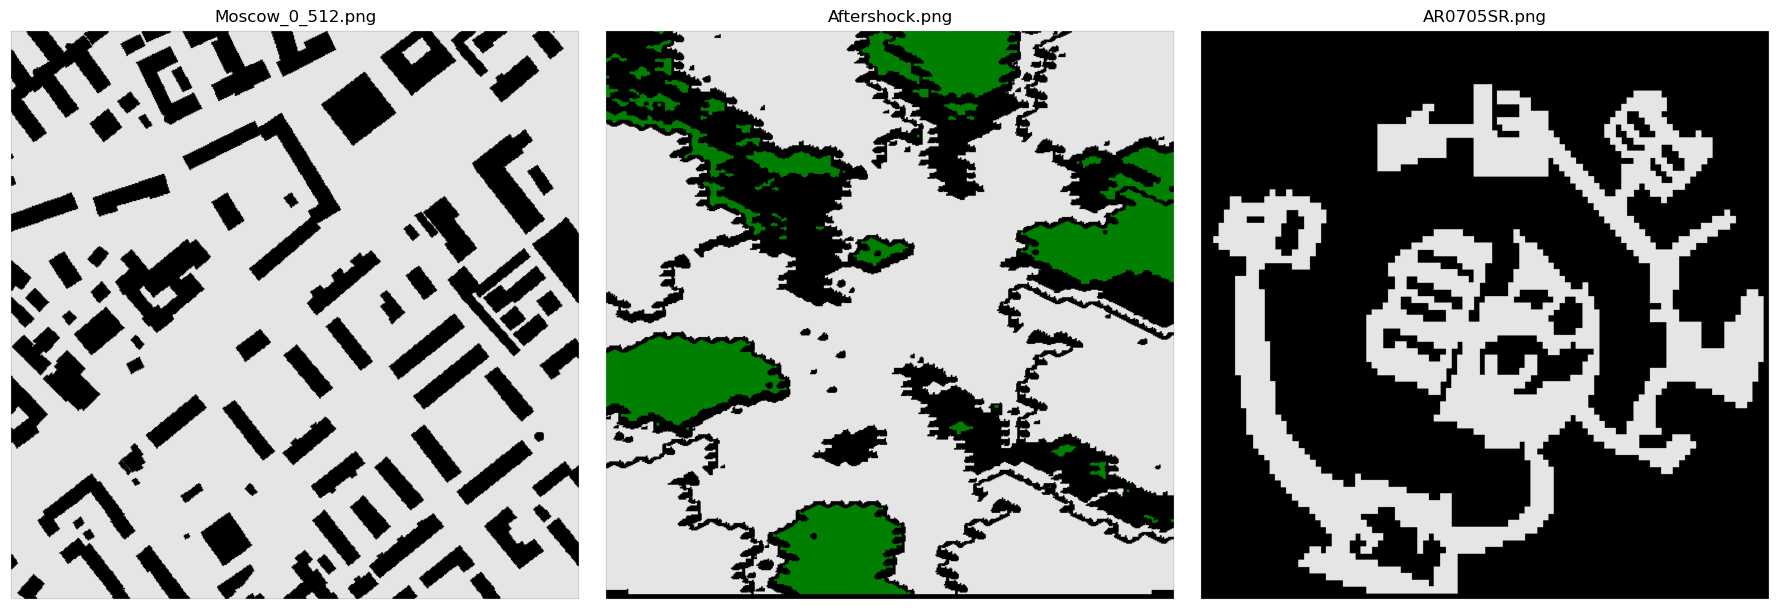

In [9]:
map_images = [
    Image.open('data/Moscow_0_512.png'), 
    Image.open('data/Aftershock.png'), 
    Image.open('data/AR0705SR.png')
    ]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
for i in range(len(map_images)):
    axs[i].imshow(map_images[i])
    axs[i].axis('off')
    axs[i].set_title(map_images[i].filename.split('/')[1])     

plt.tight_layout()
plt.show()

### Определим необходимые классы для тестирования алгоритмов.

In [2]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 8-connected, allowing moves in all directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        d_delta = ((1, 1), (1, -1), (-1, -1), (-1, 1))
        hv_delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        
        for dx, dy in hv_delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))
        
        for dx, dy in d_delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj) and self.is_not_cutting_edge_move(i, j, ni, nj):
                neighbors.append((ni, nj))
        
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width
    
    def is_not_cutting_edge_move(self, i1: int, j1: int, i2: int, j2: int) -> bool:
        """
        Checks if the move (i1, j1) -> (i2, j2) is not cutting-edge.

        Parameters
        ----------
        i1 : int
            Row number of the first cell in the grid.
        j1 : int
            Column number of the first cell in the grid.
        i2 : int
            Row number of the second cell in the grid.
        j2 : int
            Column number of the second cell in the grid.

        Returns
        ----------
        bool
            True if the move is allowed (not cutting-edge), False if it's blocked.
        """
        return self.traversable(i1, j2) and self.traversable(i2, j1)

In [3]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '#' for obstacles and '.' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('#' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[1 if (char == "@" or char == "T") else 0 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return np.transpose(cells)

In [4]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal and diagonal moves are supported).
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1:  # Diagonal move
        return np.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal and diagonal moves are supported.")

In [5]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        if self.i != other.i or self.j != other.j:
            return False
        return True

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

### SearchTree

In [6]:
class SearchTreePQD: # SearchTree which uses priority queue for OPEN and dict for CLOSED
    
    def __init__(self):
        self._open = []   # prioritized queue for the OPEN nodes
        self._closed = dict()         # dict for the expanded nodes = CLOSED
        self._enc_open_dublicates = 0  # the number of dublicates encountered in OPEN
                                      
    def __len__(self):
        """
        This gives the size of the search tree. Typically, we want to know 
        the size of the search tree at the last iteration of the search 
        to assess the memory footprint of the algorithm.
        """
        return len(self._open) + len(self._closed)
                
    def open_is_empty(self) -> bool:
        """
        open_is_empty should inform whether the OPEN is exhausted or not.
        In the former case the search main loop should be interrupted.
        """
        return len(self._open) == 0
    

    def add_to_open(self, item: Node):
        """
        Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
        It's either a totally new node (the one we never encountered before)
        or it can be a dublicate of the node that currently resides in OPEN.
        In this implementation we will detect dublicates lazily, thus at this
        point we dont care about them and just add a node to OPEN.
        """   
        heappush(self._open, item)
    
    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Extracting the best node (i.e. the one with the minimal key) from OPEN.
        This node will be expanded further on in the main loop of the search.
        
        This is here where we must take care of the dublicates and discard the
        node if it was previously expanded (=resides in CLOSED) and take the next node.
        
        If OPEN becomes empty then we should return None.
        
        """ 
        if not self._open:
            return None

        best_node = heappop(self._open)
        while self.was_expanded(best_node):
            self._enc_open_dublicates += 1
            if not self.open_is_empty():
                best_node = heappop(self._open)
            else:
                return None
        return best_node
        

    def add_to_closed(self, item: Node):
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        return item in self._closed
    
    @property
    def opened(self):
        return self._open
    
    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

### Определим класс `Task` для хранения необходимой информации о задании.

In [7]:
class Task:
    """
    Represents a task for search algorithm.

    Attributes
    ----------
    map : Map
        Map to execute task on.

    start_i : int
        First coordinate of start position.

    start_j : int
        Second coordinate of start position.

    goal_i : int
        First coordinate of goal position.

    goal_j : int
        Second coordinate of goal position.

    length : float
        Length of shortest path on map.
    """

    def __init__(
            self, 
            task_map: Map,
            start_i: int,
            start_j: int,
            goal_i: int,
            goal_j: int,
            length: float,
    ):
        """
        Initializes the task.
        """
        self.map = task_map
        self.start_i = start_i
        self.start_j = start_j
        self.goal_i = goal_i
        self.goal_j = goal_j
        self.length = length
        
        # Константа для проверки корректности длины пути
        self.eps = 1e-6

    def __repr__(self):
        return f"Start_i: {self.start_i}; Start_j: {self.start_j}; Goal_i: {self.goal_i}; Goal_j: {self.goal_j}; Length: {self.length}"

    def is_correct_length(self, length: float) -> bool:
        return abs(self.length - length) < self.eps

In [8]:
def make_path(
    goal: Node
) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

### Определим эвристику -- `Octile distance`

In [20]:
def octile_distance(
    i1: int, j1: int, i2: int, j2: int
) -> float:
    """
    Computes the Octile distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Manhattan distance between the two cells.
    """
    dx = abs(i1 - i2)
    dy = abs(j1 - j2)
    return abs(dx - dy) + D_STEP_COST * min(dx, dy)

### Определим алгоритмы A* и WA*

In [21]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    
    ast = search_tree()  # A* search tree
    steps = 0
    search_tree_size = 0
    step_cost = HV_STEP_COST

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        node_to_expand = ast.get_best_node_from_open()

        if node_to_expand is None:
            return False, None, steps, len(ast)

        if node_to_expand.i == goal_i and node_to_expand.j == goal_j:
            return True, node_to_expand, steps, len(ast)

        ast.add_to_closed(node_to_expand)
        successors = task_map.get_neighbors(node_to_expand.i, node_to_expand.j)
        for successor in successors:
            
            if abs(node_to_expand.i - successor[0]) == 1 and abs(node_to_expand.j - successor[1]) == 1:
                step_cost = D_STEP_COST
            elif abs(node_to_expand.i - successor[0]) + abs(node_to_expand.j - successor[1]) == 1:
                step_cost = HV_STEP_COST
            successor_node = Node(i=successor[0], j=successor[1], g=node_to_expand.g+step_cost, 
                                  h=heuristic_func(successor[0], successor[1], goal_i, goal_j))
            successor_node.f = successor_node.g + successor_node.h    
            successor_node.parent = node_to_expand
            ast.add_to_open(successor_node)
    
    search_tree_size = len(ast)
    return False, None, steps, search_tree_size

In [22]:
WA_STAR_WEIGHTS = [1.2, 1.5, 1.75, 2.0, 3.0]

In [23]:
def wastar(
    weight : float,
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    
    ast = search_tree()  # WA* search tree
    steps = 0
    search_tree_size = 0
    step_cost = HV_STEP_COST

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        node_to_expand = ast.get_best_node_from_open()

        if node_to_expand is None:
            return False, None, steps, len(ast)

        if node_to_expand.i == goal_i and node_to_expand.j == goal_j:
            return True, node_to_expand, steps, len(ast)

        ast.add_to_closed(node_to_expand)
        successors = task_map.get_neighbors(node_to_expand.i, node_to_expand.j)
        for successor in successors:
            
            if abs(node_to_expand.i - successor[0]) == 1 and abs(node_to_expand.j - successor[1]) == 1:
                step_cost = D_STEP_COST
            elif abs(node_to_expand.i - successor[0]) + abs(node_to_expand.j - successor[1]) == 1:
                step_cost = HV_STEP_COST
            successor_node = Node(i=successor[0], j=successor[1], g=node_to_expand.g+step_cost, 
                                  h=heuristic_func(successor[0], successor[1], goal_i, goal_j))
            successor_node.f = successor_node.g + weight * successor_node.h
            successor_node.parent = node_to_expand
            ast.add_to_open(successor_node)
    
    search_tree_size = len(ast)
    return False, None, steps, search_tree_size

### Визуализация карт

In [98]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
    nodes_reexpanded: Optional[Iterable[Node]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[Node]]
        Nodes that were re-expanded during the search process.
    """
    scale = 8
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))
    
    start_neighbours = grid_map.get_neighbors(start.i, start.j)
    for node in start_neighbours:
        node_neighbours = grid_map.get_neighbors(node[0], node[1])
        for n_node in node_neighbours:
            if n_node is not None and grid_map.traversable(n_node[0], n_node[1]):
                draw_rectangle(draw, Node(n_node[0], n_node[1]), scale, (40, 180, 99))    
        
        if node is not None and grid_map.traversable(node[0], node[1]):
            draw_rectangle(draw, Node(node[0], node[1]), scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    goal_neighbours = grid_map.get_neighbors(goal.i, goal.j)
    for node in goal_neighbours:
        node_neighbours = grid_map.get_neighbors(node[0], node[1])
        for n_node in node_neighbours:
            if n_node is not None and grid_map.traversable(n_node[0], n_node[1]):
                draw_rectangle(draw, Node(n_node[0], n_node[1]), scale, (231, 76, 60))  

        if node is not None and grid_map.traversable(node[0], node[1]):
            draw_rectangle(draw, Node(node[0], node[1]), scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=200)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

### Заведем несколько утилит для работы с файлами

In [24]:
def read_map_from_file(
    path: str,
) -> npt.NDArray:
    """
    Reads map from a file.

    Parameters
    ----------
    path : str
        Path to a file with the pathfinding problem instance.

    Returns
    -------
    cells : npt.NDArray
        Matrix of grid map cells.
    """
    with open(path) as map_file:
        next(map_file)
        height = int(next(map_file).split(' ')[1])
        width = int(next(map_file).split(' ')[1])
        next(map_file)

        # Read the map section
        map_lines = [next(map_file) for _ in range(height)]
        map_str = "".join(map_lines)
        cells = convert_string_to_cells(map_str)

    return cells

In [25]:
def read_tasks_from_file(
    path: str,
    task_map: Map
) -> npt.NDArray:
    """
    Reads tasks from a file.

    Parameters
    ----------
    path : str
        Path to a file with the pathfinding problem instances.

    number_of_tasks : int
        The number of tasks to be read from the file.
            
    Returns
    -------
    starts, goals, lengths : Tuple[list, list, list]
        Tasks.
    """

    batch_numbers = [0, 19, 39, 59, 79, 99, 119, 139, 149, 159, 169]
    tasks = []

    with open(path) as tasks_file:
        # Skip line with version of file
        next(tasks_file)

        for _ in range((batch_numbers[-1] + 1) * 10 + 1):
            task_info = next(tasks_file).split('\t')
            if int(task_info[0]) not in batch_numbers:
                continue

            task = Task(
                task_map=task_map,
                start_i=int(task_info[4]),
                start_j=int(task_info[5]),
                goal_i=int(task_info[6]),
                goal_j=int(task_info[7]),
                length=float(task_info[8][:-2])
            )
            tasks.append(task)  

    return np.array(tasks)

### Утилиты для одиночного и массированного тестирования

In [26]:
def single_task_test(
    is_weighted_astar: bool,
    task: Task,
    weight: float = None,
    verbose: bool = False,
) -> Tuple[float | None, int, int, bool] | None:
    '''
    Returns:
        Tuple[path_length, search_tree_size, number_of_steps, correctness]
    '''

    try:
        result = None
        if is_weighted_astar:
            result = wastar(weight, task.map, task.start_i, task.start_j, task.goal_i, task.goal_j, octile_distance, SearchTreePQD)
        else:
            result = astar(task.map, task.start_i, task.start_j, task.goal_i, task.goal_j, octile_distance, SearchTreePQD)

        (found, end_node, number_of_steps, search_tree_size) = result
        if found:
            _, path_length = make_path(end_node)
            correct = task.is_correct_length(length=path_length)
            if verbose:
                print(
                    f"Path found! Length: {path_length} \t Search tree size: {search_tree_size} \t Number of steps: {number_of_steps} \t Correct: {correct}"
                )
            return (path_length, search_tree_size, number_of_steps, correct)
        else:
            raise ValueError("Path not found.")
    

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()
        return None

In [27]:
def massive_map_test(
    is_weighted_astar: bool,
    tasks: npt.NDArray,
    weight: float = None,
    verbose: bool = False,
) -> npt.NDArray:
    
    all_tasks_correct = True
    number_failed_tasks = 0
    number_of_tasks = len(tasks) 
    results = []

    for i in range(number_of_tasks):
        start_time = time.time()
        test_result = single_task_test(
                        is_weighted_astar=is_weighted_astar,
                        weight=weight,
                        task=tasks[i],
                        verbose=verbose
                      )
        
        execution_time = time.time() - start_time
        if not test_result[3]:
            if all_tasks_correct:
                all_tasks_correct = False
            number_failed_tasks += 1

        results.append((execution_time,) + test_result)
    
    if all_tasks_correct:
        print("All tasks correct")
    else:
        print(f"Percent of correct tasks: {round((1 - number_failed_tasks / number_of_tasks) * 100, 2)}%")
    return np.array(results)

## Приступим к бенчмаркингу

### 1. Moscow map benchmarking
Запускаем все алгоритмы на одном и том же наборе заданий

Результат выполнения задания: `время работы`, `длина пути`, `размер дерева поиска`, `количество шагов`, `корректность`.

A* гарантирует нахождение оптимального (то есть кратчайшего) пути. WA* этого не гарантирует. Мы будем фиксировать длину пути, найденного алгоритмом WA*.


In [65]:
Moscow_map = Map(read_map_from_file(path="data/Moscow_0_512.map"))
Moscow_tasks = read_tasks_from_file(task_map=Moscow_map, path="data/Moscow_0_512.map.scen")

In [66]:
print(Moscow_tasks[0])
print(Moscow_tasks[1])
print(Moscow_tasks[2], end='\n\n')

single_task_test(task=Moscow_tasks[0], is_weighted_astar=False, verbose=True)
single_task_test(task=Moscow_tasks[1], is_weighted_astar=False, verbose=True)
_ = single_task_test(task=Moscow_tasks[2], is_weighted_astar=False, verbose=True)


Start_i: 44; Start_j: 96; Goal_i: 41; Goal_j: 97; Length: 3.4142135
Start_i: 144; Start_j: 386; Goal_i: 146; Goal_j: 385; Length: 2.4142135
Start_i: 204; Start_j: 418; Goal_i: 202; Goal_j: 417; Length: 2.4142135

Path found! Length: 3.414213562373095 	 Search tree size: 40 	 Number of steps: 6 	 Correct: True
Path found! Length: 2.414213562373095 	 Search tree size: 24 	 Number of steps: 4 	 Correct: True
Path found! Length: 2.414213562373095 	 Search tree size: 24 	 Number of steps: 4 	 Correct: True


### 1.1. A*

In [67]:
%time Moscow_a_star_results = massive_map_test(is_weighted_astar=False, tasks=Moscow_tasks)

All tasks correct
CPU times: user 1min, sys: 83.8 ms, total: 1min
Wall time: 1min 1s


### 1.2. WA* weight = 1.2

In [68]:
%time Moscow_weight_0_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[0], tasks=Moscow_tasks)

Percent of correct tasks: 27.27%
CPU times: user 8.65 s, sys: 1.01 ms, total: 8.66 s
Wall time: 8.66 s


### 1.3. WA* weight = 1.5

In [69]:
%time Moscow_weight_1_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[1], tasks=Moscow_tasks)

Percent of correct tasks: 22.73%
CPU times: user 4.15 s, sys: 0 ns, total: 4.15 s
Wall time: 4.15 s


### 1.4. WA* weight = 1.75

In [70]:
%time Moscow_weight_2_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[2], tasks=Moscow_tasks)

Percent of correct tasks: 21.82%
CPU times: user 3.2 s, sys: 5.99 ms, total: 3.2 s
Wall time: 3.2 s


### 1.5. WA* weight = 2.0

In [71]:
%time Moscow_weight_3_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[3], tasks=Moscow_tasks)

Percent of correct tasks: 21.82%
CPU times: user 2.61 s, sys: 988 µs, total: 2.61 s
Wall time: 2.61 s


### 1.6. WA* weight = 3.0

In [72]:
%time Moscow_weight_4_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[4], tasks=Moscow_tasks)

Percent of correct tasks: 19.09%
CPU times: user 2.09 s, sys: 992 µs, total: 2.09 s
Wall time: 2.09 s


### 2. Aftershock map benchmarking

In [73]:
Aftershock_map = Map(read_map_from_file(path="data/Aftershock.map"))
Aftershock_tasks = read_tasks_from_file(task_map=Aftershock_map, path="data/Aftershock.map.scen")

In [74]:
print(Aftershock_tasks[0])
print(Aftershock_tasks[1])
print(Aftershock_tasks[2], end='\n\n')

single_task_test(task=Aftershock_tasks[0], is_weighted_astar=False, verbose=True)
single_task_test(task=Aftershock_tasks[1], is_weighted_astar=False, verbose=True)
_ = single_task_test(task=Aftershock_tasks[2], is_weighted_astar=False, verbose=True)

Start_i: 363; Start_j: 438; Goal_i: 366; Goal_j: 436; Length: 3.8284271
Start_i: 340; Start_j: 298; Goal_i: 338; Goal_j: 300; Length: 2.8284271
Start_i: 264; Start_j: 182; Goal_i: 266; Goal_j: 185; Length: 3.8284271

Path found! Length: 3.82842712474619 	 Search tree size: 23 	 Number of steps: 4 	 Correct: True
Path found! Length: 2.8284271247461903 	 Search tree size: 16 	 Number of steps: 3 	 Correct: True
Path found! Length: 3.82842712474619 	 Search tree size: 24 	 Number of steps: 4 	 Correct: True


### 2.1. A*

In [75]:
%time Aftershock_a_star_results = massive_map_test(is_weighted_astar=False, tasks=Aftershock_tasks)

All tasks correct
CPU times: user 1min 7s, sys: 52.9 ms, total: 1min 7s
Wall time: 1min 7s


### 2.2. WA* weight = 1.2

In [76]:
%time Aftershock_weight_0_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[0], tasks=Aftershock_tasks)

Percent of correct tasks: 38.18%
CPU times: user 35.7 s, sys: 2.99 ms, total: 35.7 s
Wall time: 35.8 s


### 2.3. WA* weight = 1.5

In [77]:
%time Aftershock_weight_1_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[1], tasks=Aftershock_tasks)

Percent of correct tasks: 29.09%
CPU times: user 25.8 s, sys: 7 ms, total: 25.8 s
Wall time: 25.8 s


### 2.4. WA* weight = 1.75

In [78]:
%time Aftershock_weight_2_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[2], tasks=Aftershock_tasks)

Percent of correct tasks: 28.18%
CPU times: user 20.9 s, sys: 3.97 ms, total: 20.9 s
Wall time: 20.9 s


### 2.5. WA* weight = 2.0

In [79]:
%time Aftershock_weight_3_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[3], tasks=Aftershock_tasks)

Percent of correct tasks: 24.55%
CPU times: user 19.5 s, sys: 3.98 ms, total: 19.6 s
Wall time: 19.6 s


### 2.6. WA* weight = 3.0

In [80]:
%time Aftershock_weight_4_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[4], tasks=Aftershock_tasks)

Percent of correct tasks: 19.09%
CPU times: user 17.7 s, sys: 1.98 ms, total: 17.7 s
Wall time: 17.7 s


### 3. AR0705SR map benchmarking

In [28]:
AR0705SR_map = Map(read_map_from_file(path="data/AR0705SR.map"))
AR0705SR_tasks = read_tasks_from_file(task_map=AR0705SR_map, path="data/AR0705SR.map.scen")

In [29]:
print(AR0705SR_tasks[0])
print(AR0705SR_tasks[1])
print(AR0705SR_tasks[2], end='\n\n')

single_task_test(task=AR0705SR_tasks[0], is_weighted_astar=False, verbose=True)
single_task_test(task=AR0705SR_tasks[1], is_weighted_astar=False, verbose=True)
_ = single_task_test(task=AR0705SR_tasks[2], is_weighted_astar=False, verbose=True)

Start_i: 427; Start_j: 225; Goal_i: 425; Goal_j: 223; Length: 2.8284271
Start_i: 63; Start_j: 161; Goal_i: 65; Goal_j: 160; Length: 2.4142135
Start_i: 190; Start_j: 439; Goal_i: 188; Goal_j: 440; Length: 2.4142135

Path found! Length: 2.8284271247461903 	 Search tree size: 16 	 Number of steps: 3 	 Correct: True
Path found! Length: 2.414213562373095 	 Search tree size: 24 	 Number of steps: 4 	 Correct: True
Path found! Length: 2.414213562373095 	 Search tree size: 24 	 Number of steps: 4 	 Correct: True


### 3.1. A*

In [30]:
%time AR0705SR_a_star_results = massive_map_test(is_weighted_astar=False, tasks=AR0705SR_tasks)

All tasks correct
CPU times: user 32.6 s, sys: 2.57 ms, total: 32.6 s
Wall time: 32.6 s


### 3.2. WA* weight = 1.2

In [31]:
%time AR0705SR_weight_0_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[0], tasks=AR0705SR_tasks)

Percent of correct tasks: 49.09%
CPU times: user 28.7 s, sys: 4.91 ms, total: 28.7 s
Wall time: 28.7 s


### 3.3. WA* weight = 1.5

In [32]:
%time AR0705SR_weight_1_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[1], tasks=AR0705SR_tasks)

Percent of correct tasks: 38.18%
CPU times: user 25.1 s, sys: 0 ns, total: 25.1 s
Wall time: 25.1 s


### 3.4. WA* weight = 1.75

In [33]:
%time AR0705SR_weight_2_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[2], tasks=AR0705SR_tasks)

Percent of correct tasks: 35.45%
CPU times: user 22.2 s, sys: 1.95 ms, total: 22.2 s
Wall time: 22.2 s


### 3.5. WA* weight = 2.0

In [34]:
%time AR0705SR_weight_3_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[3], tasks=AR0705SR_tasks)

Percent of correct tasks: 34.55%
CPU times: user 20.9 s, sys: 994 µs, total: 20.9 s
Wall time: 20.9 s


### 3.6. WA* weight = 3.0

In [35]:
%time AR0705SR_weight_4_results = massive_map_test(is_weighted_astar=True, weight=WA_STAR_WEIGHTS[4], tasks=AR0705SR_tasks)

Percent of correct tasks: 17.27%
CPU times: user 19.1 s, sys: 1.99 ms, total: 19.1 s
Wall time: 19.1 s


## Визуализация результатов

In [36]:
tasks_number = 110

def task_corectness(task_results: npt.NDArray):
    return round(1 - (task_results[task_results[:, 4] == False].shape[0] / tasks_number), 2)

### Корректность выполненных заданий

Проверим, насколько часто WA* находит оптимальный путь (то есть путь такой же длины, как у пути, найденного алгоритмом A*).

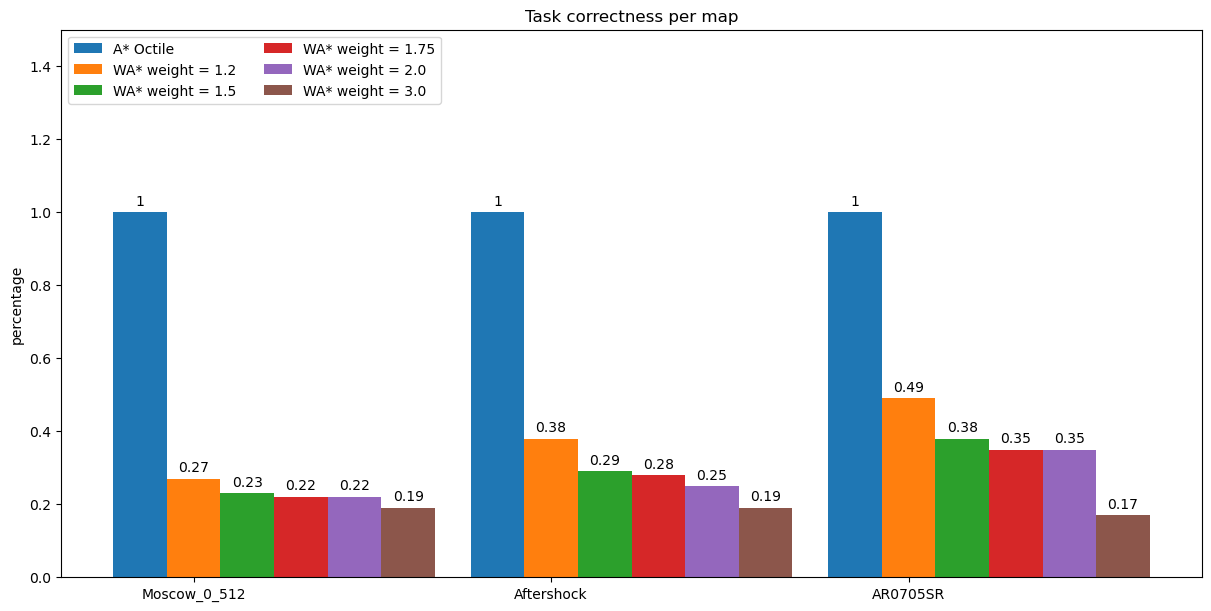

In [124]:
maps = ("Moscow_0_512", "Aftershock", "AR0705SR")
correctness_per_heuristic = {
    'A* Octile': (
        task_corectness(Moscow_a_star_results), 
        task_corectness(Aftershock_a_star_results), 
        task_corectness(AR0705SR_a_star_results)
    ),
    'WA* weight = 1.2': (
        task_corectness(Moscow_weight_0_results), 
        task_corectness(Aftershock_weight_0_results), 
        task_corectness(AR0705SR_weight_0_results)
    ),
    'WA* weight = 1.5': (
        task_corectness(Moscow_weight_1_results), 
        task_corectness(Aftershock_weight_1_results), 
        task_corectness(AR0705SR_weight_1_results)
    ),
    'WA* weight = 1.75': (
        task_corectness(Moscow_weight_2_results), 
        task_corectness(Aftershock_weight_2_results), 
        task_corectness(AR0705SR_weight_2_results)
    ),
    'WA* weight = 2.0': (
        task_corectness(Moscow_weight_3_results), 
        task_corectness(Aftershock_weight_3_results), 
        task_corectness(AR0705SR_weight_3_results)
    ),
    'WA* weight = 3.0': (
        task_corectness(Moscow_weight_4_results), 
        task_corectness(Aftershock_weight_4_results), 
        task_corectness(AR0705SR_weight_4_results)
    ),
}

x = np.arange(len(maps))
width = 0.15
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))

for attribute, measurement in correctness_per_heuristic.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('percentage')
ax.set_title('Task correctness per map')
ax.set_xticks(x + width, maps)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1.5)

plt.show()

Результаты вполне ожидаемые. 
- `Moscow_0_512`: На карте множество препятствий (здания), множество возможных путей, поэтому процент корректных путей минимален среди трех карт.
- `Aftershock`: На этой карте, в отличии от `Moscow_0_512`, меньше препятствий, что немного увеличило количество правильных решений.
- `AR0705SR`: Самые большие результаты у этой карты, благодаря двум довольно узким коридорам.

Стоит заметить, что большая часть корректных решений WA* -- это **простые задания** с небольшой длиной оптимального пути.

### Нормализация результатов работы WA* относительно A*
Транспонирование нужно для более удобной работы с данными

In [115]:
normalized_Moscow_weight_0 = (Moscow_weight_0_results / Moscow_a_star_results).T
normalized_Moscow_weight_1 = (Moscow_weight_1_results / Moscow_a_star_results).T
normalized_Moscow_weight_2 = (Moscow_weight_2_results / Moscow_a_star_results).T
normalized_Moscow_weight_3 = (Moscow_weight_3_results / Moscow_a_star_results).T
normalized_Moscow_weight_4 = (Moscow_weight_4_results / Moscow_a_star_results).T

In [116]:
normalized_Aftershock_weight_0 = (Aftershock_weight_0_results / Aftershock_a_star_results).T
normalized_Aftershock_weight_1 = (Aftershock_weight_1_results / Aftershock_a_star_results).T
normalized_Aftershock_weight_2 = (Aftershock_weight_2_results / Aftershock_a_star_results).T
normalized_Aftershock_weight_3 = (Aftershock_weight_3_results / Aftershock_a_star_results).T
normalized_Aftershock_weight_4 = (Aftershock_weight_4_results / Aftershock_a_star_results).T

In [117]:
normalized_AR0705SR_weight_0 = (AR0705SR_weight_0_results / AR0705SR_a_star_results).T
normalized_AR0705SR_weight_1 = (AR0705SR_weight_1_results / AR0705SR_a_star_results).T
normalized_AR0705SR_weight_2 = (AR0705SR_weight_2_results / AR0705SR_a_star_results).T
normalized_AR0705SR_weight_3 = (AR0705SR_weight_3_results / AR0705SR_a_star_results).T
normalized_AR0705SR_weight_4 = (AR0705SR_weight_4_results / AR0705SR_a_star_results).T

### Количество шагов, совершенных алгоритмом

Проверим, насколько меньше алгоритм WA* совершает шагов при решении задач, чем A*.

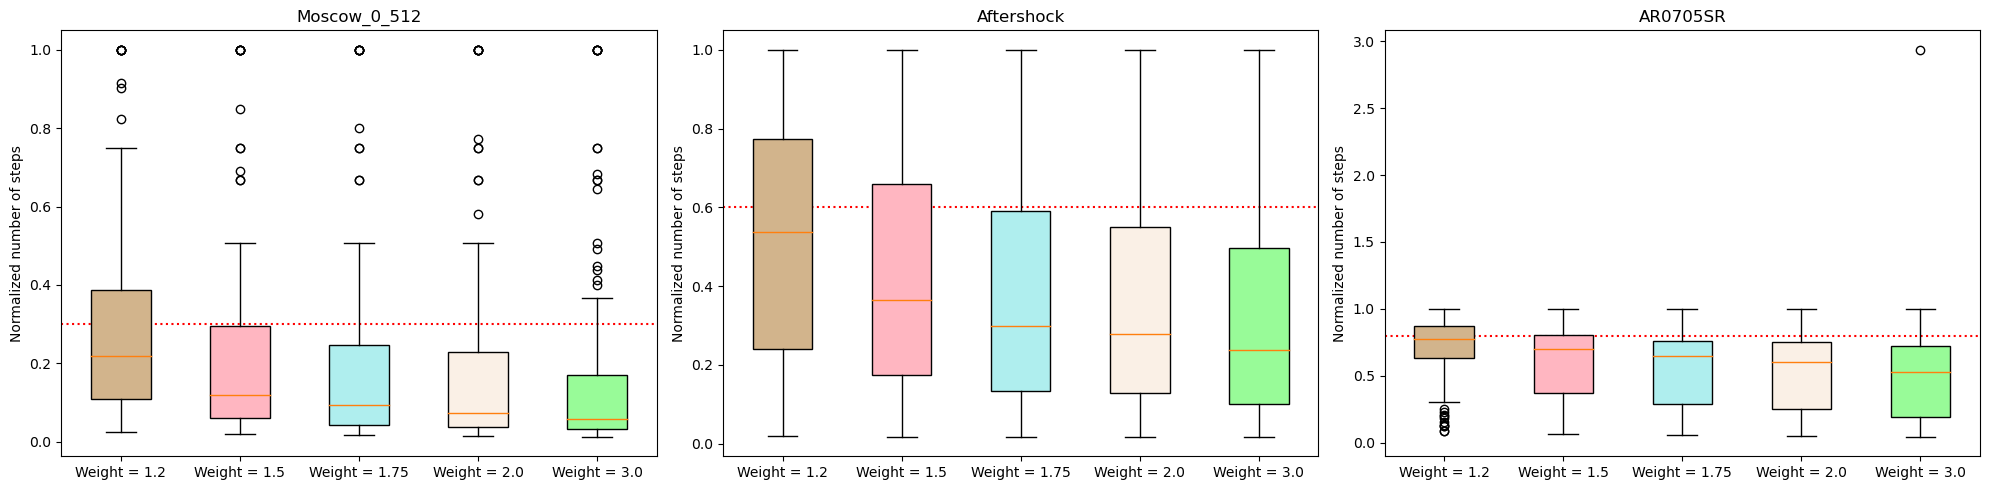

In [85]:
steps_Moscow = [
    normalized_Moscow_weight_0[3],
    normalized_Moscow_weight_1[3],
    normalized_Moscow_weight_2[3],
    normalized_Moscow_weight_3[3],
    normalized_Moscow_weight_4[3],
]
steps_Aftershock = [
    normalized_Aftershock_weight_0[3],
    normalized_Aftershock_weight_1[3],
    normalized_Aftershock_weight_2[3],
    normalized_Aftershock_weight_3[3],
    normalized_Aftershock_weight_4[3],
]
steps_AR0705SR = [
    normalized_AR0705SR_weight_0[3],
    normalized_AR0705SR_weight_1[3],
    normalized_AR0705SR_weight_2[3],
    normalized_AR0705SR_weight_3[3],
    normalized_AR0705SR_weight_4[3],
]

labels = ['Weight = 1.2', 'Weight = 1.5', 'Weight = 1.75', 'Weight = 2.0', 'Weight = 3.0']
colors = ['tan', 'lightpink', 'paleturquoise', 'linen', 'palegreen']
bplots = []

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].set_title("Moscow_0_512")
ax[0].set_ylabel('Normalized number of steps')
ax[0].axhline(y=0.3, color='r', linestyle=':')
bplots.append(ax[0].boxplot(steps_Moscow, patch_artist=True, labels=labels)) 

ax[1].set_title("Aftershock")
ax[1].set_ylabel('Normalized number of steps')
ax[1].axhline(y=0.6, color='r', linestyle=':')
bplots.append(ax[1].boxplot(steps_Aftershock, patch_artist=True, labels=labels)) 

ax[2].set_title("AR0705SR")
ax[2].set_ylabel('Normalized number of steps')
ax[2].axhline(y=0.8, color='r', linestyle=':')
bplots.append(ax[2].boxplot(steps_AR0705SR, patch_artist=True, labels=labels)) 

for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.tight_layout()
plt.show()

Как мы видим, WA* делает значительно меньше шагов, чем A*. 

На карте `Moscow_0_512` медианнное число шагов не превосходит и трети количества шагов A*, однако есть выбросы, достигающие значений A*.

На карте `Aftershock` и медиана, и усики box plot'ов находятся выше. Скорее всего, это связано с тем, что карта довольно просторная, препятствий намного меньше, чем на первой карте.

Аналогичная ситуация и на карте `AR0705SR`: медианы не превосходят 80% от числа шагов A*.

Найдем задание, в котором WA* с весом 3.0 сделал в ***3*** раза больше шагов, чем A*.

In [43]:
indice = np.where(normalized_AR0705SR_weight_4[3] >= 2.5)
indice

(array([14]),)

In [90]:
print(AR0705SR_tasks[14], end='\n\n')

single_task_test(task=AR0705SR_tasks[14], is_weighted_astar=False, verbose=True)
single_task_test(task=AR0705SR_tasks[14], is_weighted_astar=True, weight=WA_STAR_WEIGHTS[0], verbose=True)
single_task_test(task=AR0705SR_tasks[14], is_weighted_astar=True, weight=WA_STAR_WEIGHTS[1], verbose=True)
single_task_test(task=AR0705SR_tasks[14], is_weighted_astar=True, weight=WA_STAR_WEIGHTS[2], verbose=True)
single_task_test(task=AR0705SR_tasks[14], is_weighted_astar=True, weight=WA_STAR_WEIGHTS[3], verbose=True)
_ = single_task_test(task=AR0705SR_tasks[14], is_weighted_astar=True, weight=WA_STAR_WEIGHTS[4], verbose=True)

Start_i: 252; Start_j: 262; Goal_i: 224; Goal_j: 328; Length: 77.5979797

Path found! Length: 77.5979797464466 	 Search tree size: 2217 	 Number of steps: 296 	 Correct: True
Path found! Length: 77.59797974644664 	 Search tree size: 433 	 Number of steps: 68 	 Correct: True
Path found! Length: 77.59797974644664 	 Search tree size: 433 	 Number of steps: 68 	 Correct: True
Path found! Length: 77.59797974644664 	 Search tree size: 438 	 Number of steps: 69 	 Correct: True
Path found! Length: 77.59797974644664 	 Search tree size: 443 	 Number of steps: 70 	 Correct: True
Path found! Length: 77.59797974644664 	 Search tree size: 1425 	 Number of steps: 869 	 Correct: True


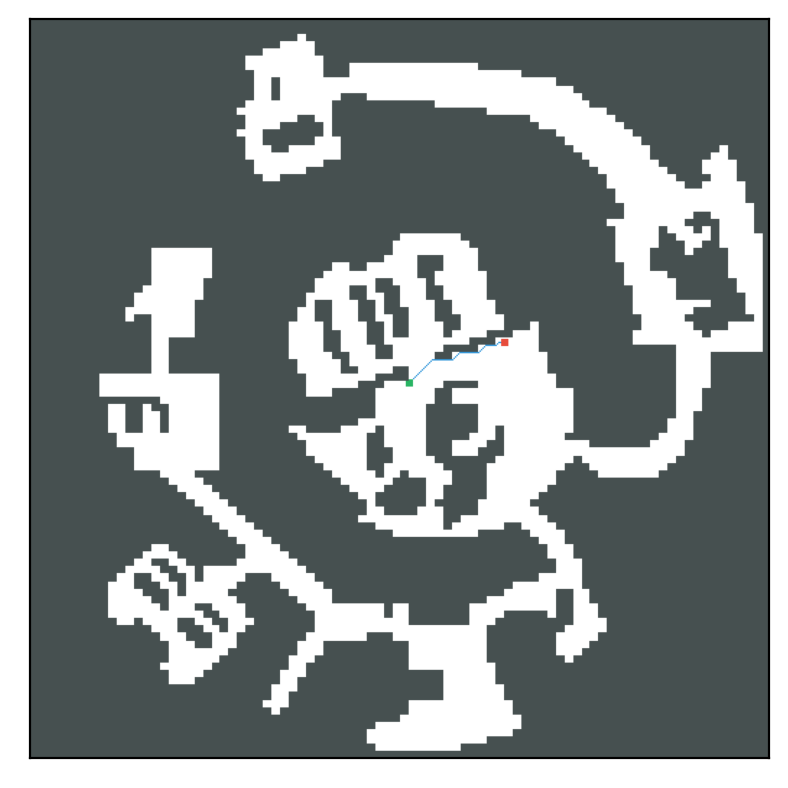

In [108]:
task_result = wastar(weight=WA_STAR_WEIGHTS[4], 
                     task_map=AR0705SR_map, 
                     start_i=252, 
                     start_j=262, 
                     goal_i=224, 
                     goal_j=328, 
                     heuristic_func=octile_distance, 
                     search_tree=SearchTreePQD
                     )
test_map = AR0705SR_map
start = Node(252, 262)
goal = Node(224, 328)
draw(test_map, start, goal, path=make_path(task_result[1])[0])

Как мы видим, путь адекватный. Скорее всего, алгоритм заносит в тупик наверх, считая от стартовой точки.

### Размер дерева поиска

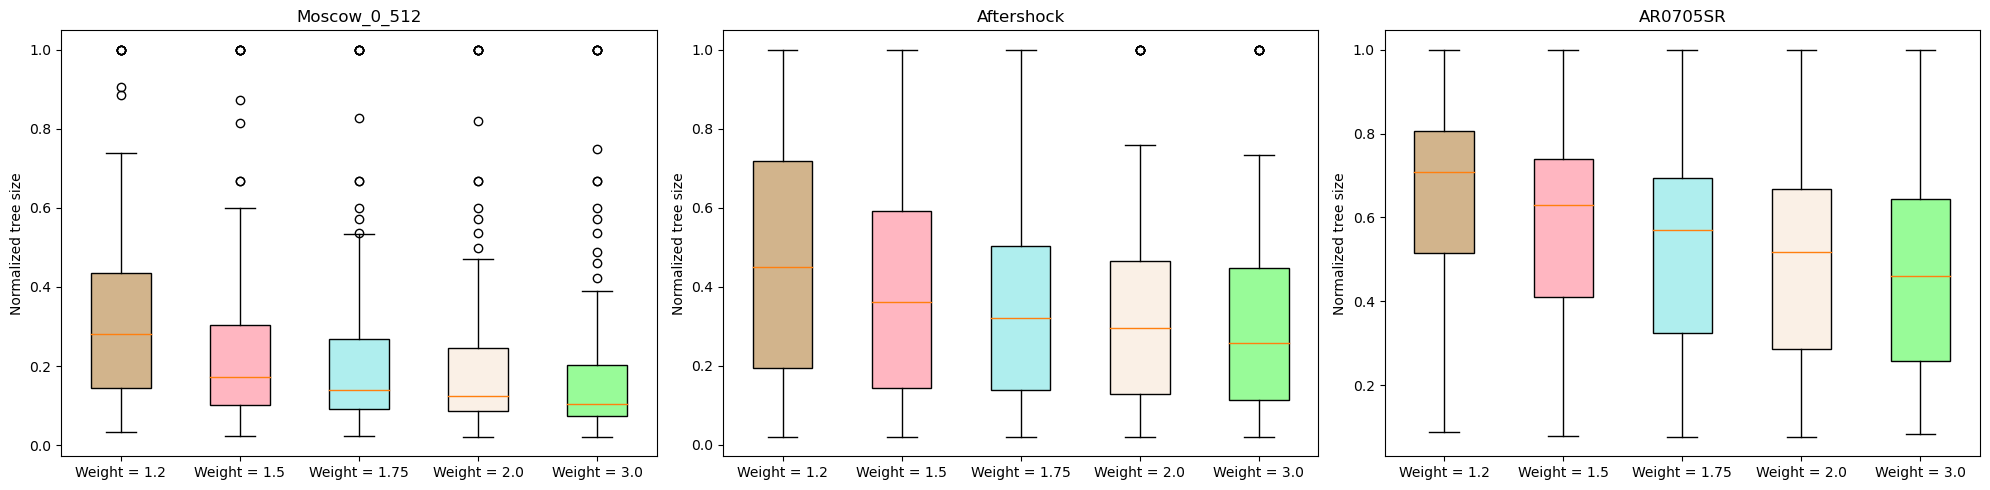

In [86]:
size_Moscow = [
    normalized_Moscow_weight_0[2],
    normalized_Moscow_weight_1[2],
    normalized_Moscow_weight_2[2],
    normalized_Moscow_weight_3[2],
    normalized_Moscow_weight_4[2],
]
size_Aftershock = [
    normalized_Aftershock_weight_0[2],
    normalized_Aftershock_weight_1[2],
    normalized_Aftershock_weight_2[2],
    normalized_Aftershock_weight_3[2],
    normalized_Aftershock_weight_4[2],
]
size_AR0705SR = [
    normalized_AR0705SR_weight_0[2],
    normalized_AR0705SR_weight_1[2],
    normalized_AR0705SR_weight_2[2],
    normalized_AR0705SR_weight_3[2],
    normalized_AR0705SR_weight_4[2],
]

labels = ['Weight = 1.2', 'Weight = 1.5', 'Weight = 1.75', 'Weight = 2.0', 'Weight = 3.0']
colors = ['tan', 'lightpink', 'paleturquoise', 'linen', 'palegreen']
bplots = []

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].set_title("Moscow_0_512")
ax[0].set_ylabel('Normalized tree size')
bplots.append(ax[0].boxplot(size_Moscow, patch_artist=True, labels=labels)) 

ax[1].set_title("Aftershock")
ax[1].set_ylabel('Normalized tree size')
bplots.append(ax[1].boxplot(size_Aftershock, patch_artist=True, labels=labels)) 

ax[2].set_title("AR0705SR")
ax[2].set_ylabel('Normalized tree size')
bplots.append(ax[2].boxplot(size_AR0705SR, patch_artist=True, labels=labels)) 

for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.tight_layout()
plt.show()

График похож на предыдущий. Можно сделать вывод о том, что на карте с множеством возможных путей (`Moscow_0_512`) алгоритм WA* показывает лучший результат в сравнении с картами, предполагающими близкие пути (`AR0705SR` со своими коридорами).

### Длина найденного пути

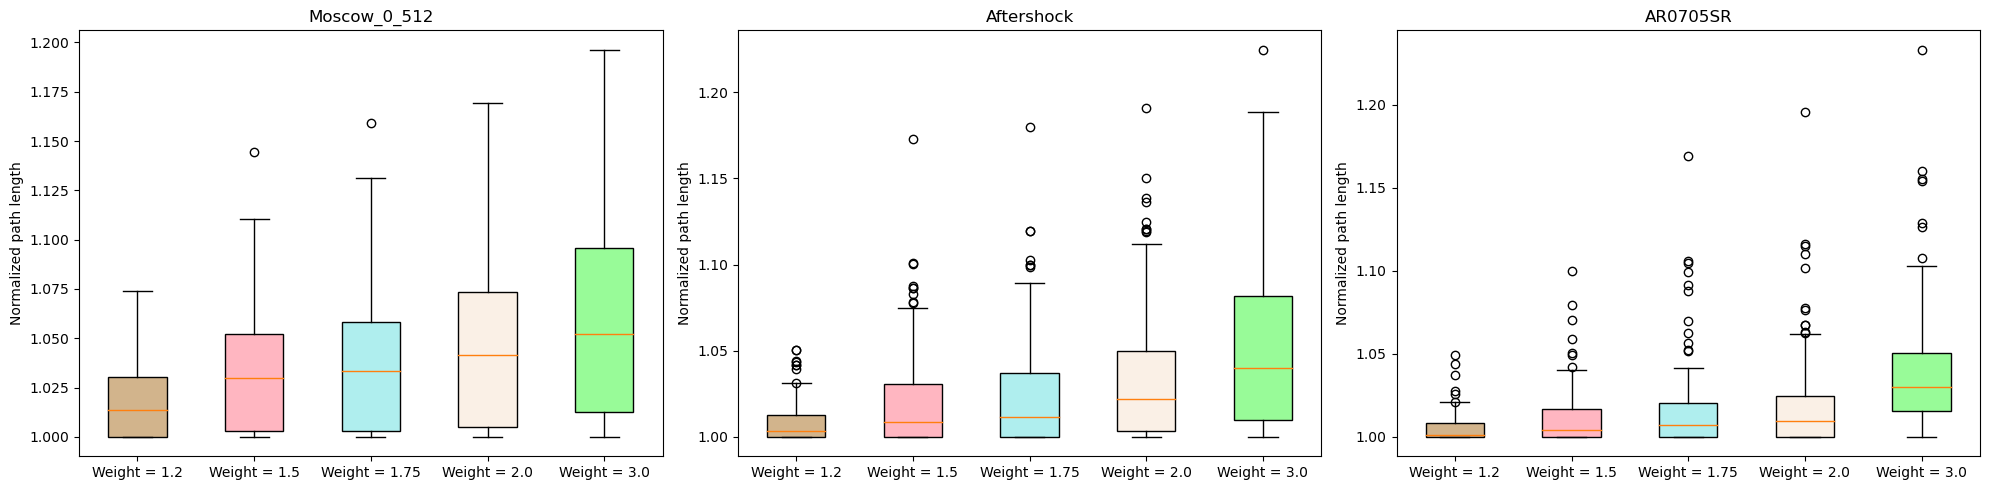

In [133]:
path_length_Moscow = [
    normalized_Moscow_weight_0[1],
    normalized_Moscow_weight_1[1],
    normalized_Moscow_weight_2[1],
    normalized_Moscow_weight_3[1],
    normalized_Moscow_weight_4[1],
]
path_length_Aftershock = [
    normalized_Aftershock_weight_0[1],
    normalized_Aftershock_weight_1[1],
    normalized_Aftershock_weight_2[1],
    normalized_Aftershock_weight_3[1],
    normalized_Aftershock_weight_4[1],
]
path_length_AR0705SR = [
    normalized_AR0705SR_weight_0[1],
    normalized_AR0705SR_weight_1[1],
    normalized_AR0705SR_weight_2[1],
    normalized_AR0705SR_weight_3[1],
    normalized_AR0705SR_weight_4[1],
]

labels = ['Weight = 1.2', 'Weight = 1.5', 'Weight = 1.75', 'Weight = 2.0', 'Weight = 3.0']
colors = ['tan', 'lightpink', 'paleturquoise', 'linen', 'palegreen']
bplots = []

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].set_title("Moscow_0_512")
ax[0].set_ylabel('Normalized path length')
bplots.append(ax[0].boxplot(path_length_Moscow, patch_artist=True, labels=labels)) 

ax[1].set_title("Aftershock")
ax[1].set_ylabel('Normalized path length')
bplots.append(ax[1].boxplot(path_length_Aftershock, patch_artist=True, labels=labels)) 

ax[2].set_title("AR0705SR")
ax[2].set_ylabel('Normalized path length')
bplots.append(ax[2].boxplot(path_length_AR0705SR, patch_artist=True, labels=labels)) 

for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.tight_layout()
plt.show()

Данный график отлично демонстрирует то, как вес в алгоритме WA* влияет на дисперсию длины пути. Чем больше вес, тем больше разброс. При весе = `1.2` длина пути практически равна длине пути, найденному алгоритмом A*.

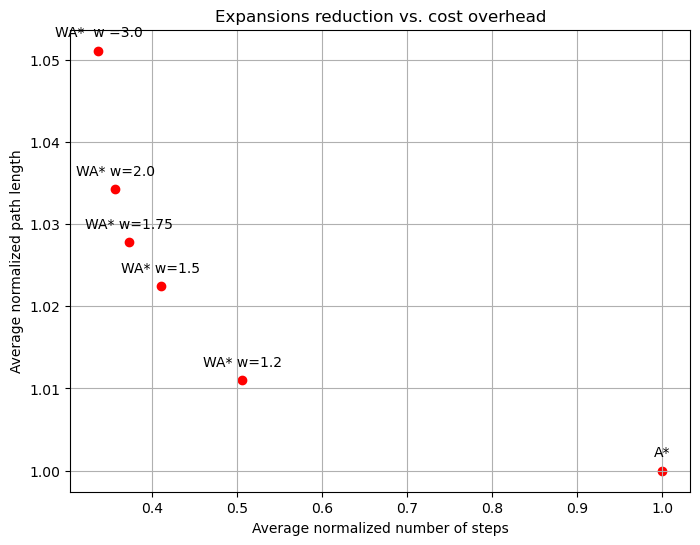

In [128]:
avg_path_length_weight_0 = ((normalized_Moscow_weight_0[1] + normalized_Aftershock_weight_0[1] + normalized_AR0705SR_weight_0[1]) / 3).mean()
avg_path_length_weight_1 = ((normalized_Moscow_weight_1[1] + normalized_Aftershock_weight_1[1] + normalized_AR0705SR_weight_1[1]) / 3).mean()
avg_path_length_weight_2 = ((normalized_Moscow_weight_2[1] + normalized_Aftershock_weight_2[1] + normalized_AR0705SR_weight_2[1]) / 3).mean()
avg_path_length_weight_3 = ((normalized_Moscow_weight_3[1] + normalized_Aftershock_weight_3[1] + normalized_AR0705SR_weight_3[1]) / 3).mean()
avg_path_length_weight_4 = ((normalized_Moscow_weight_4[1] + normalized_Aftershock_weight_4[1] + normalized_AR0705SR_weight_4[1]) / 3).mean()
avg_path_length_a_star = 1.0

avg_steps_weight_0 = ((normalized_Moscow_weight_0[3] + normalized_Aftershock_weight_0[3] + normalized_AR0705SR_weight_0[3]) / 3).mean()
avg_steps_weight_1 = ((normalized_Moscow_weight_1[3] + normalized_Aftershock_weight_1[3] + normalized_AR0705SR_weight_1[3]) / 3).mean()
avg_steps_weight_2 = ((normalized_Moscow_weight_2[3] + normalized_Aftershock_weight_2[3] + normalized_AR0705SR_weight_2[3]) / 3).mean()
avg_steps_weight_3 = ((normalized_Moscow_weight_3[3] + normalized_Aftershock_weight_3[3] + normalized_AR0705SR_weight_3[3]) / 3).mean()
avg_steps_weight_4 = ((normalized_Moscow_weight_4[3] + normalized_Aftershock_weight_4[3] + normalized_AR0705SR_weight_4[3]) / 3).mean()
avg_steps_a_star = 1.0

x = [avg_steps_weight_0, avg_steps_weight_1, avg_steps_weight_2, avg_steps_weight_3, avg_steps_weight_4, avg_steps_a_star]
y = [avg_path_length_weight_0, avg_path_length_weight_1, avg_path_length_weight_2, avg_path_length_weight_3, avg_path_length_weight_4, avg_path_length_a_star]
labels = ['WA* w=1.2', 'WA* w=1.5', 'WA* w=1.75', 'WA* w=2.0', 'WA*  w =3.0', 'A*']

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='red')

for i in range(len(x)):
    plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Expansions reduction vs. cost overhead')
plt.xlabel('Average normalized number of steps')
plt.ylabel('Average normalized path length')
plt.grid()
plt.show()

Точки, соответствующие различным версиям WA* (точнее, различным весам), образуют ветку гиперболы, прямо как на графике с лекции.
Явно проглядывается тренд повышения длины пути при увеличении веса в алгоритме WA*.

## Общий вывод

Мы провели бенчмаркинг алгоритмов WA* и A*. 

На всех трех топологически различных картах, на заданиях разных уровней сложности алгоритм WA* проявил себя хорошо. В 100% случаев выполнение задач алгоритмом WA* занимало меньше времени, чем требовалось алгоритму A*. Плата за это -- суб-оптимальность решения. Как мы увидели на графике `Длина найденного пути`, в среднем, длина пути, найденного алгоритмом WA* не превосходила 105 - 120% от оптимального пути.

Таким образом, WA* эффективен для задач, где важна скорость нахождения решения, в то время как A* обеспечивает точные результаты, но может быть медленнее в сложных пространствах поиска.